In [1]:
#Script: Tutorial for performing Analytical Rank-based Enrichment Analysis (aREA)
#Author: Somnath Tagore, Ph.D.
#Date of Creation: 02/24/2025

#Note: The following tutorial performs aREA.
#Note: It requires two inputs, a) the consensus signature, b) VUFS matrix


In [2]:
#Libraries
library(pheatmap)
library(RColorBrewer)
library(viper)
library(pheatmap)
library(ggplot2)
  
#Custom functions for plotting
quantile_breaks <- function(xs, n = 10){
  breaks <- quantile(xs, probs = seq(from = 0, to = 1, length.out = n))
  unique(breaks)
}

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

save_pheatmap_pdf <- function(x, filename, width=10, height=10) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

outersect <- function(x,y){
  sort(c(setdiff(x,y),setdiff(y,x)))
}

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




In [3]:
tcm.size<-100
# write a function to do a ggplot version of the aREA GSEA plot
aREA_GSEA_Plot <- function(current.geneset,current.sig,uniform.wts = TRUE,tcm.size,color.positive = "salmon", color.negative = "cornflowerblue",main.title = "Analytical Rank-Based Enrichment Analysis", y.label = "KS Enrichment Score", x.label = "Signature", x.step = 500, y.step = 0.1,gsea.score = 1){
  
  # load packages
  library(ggplot2)
  library(viper)
  
  # specify the gsea score to use (1 is a KS test)
  gsea.score.value <- gsea.score
  
  # compute the aREA enrichment
  current.regul <- list(tfmode = sign(current.geneset), likelihood = as.numeric(abs(current.geneset)))
  
  if(!is.null(tcm.size)){
    subset.targets <- current.regul$tfmode*current.regul$likelihood
    subset.targets <- c(sort(subset.targets,decreasing = TRUE)[seq(from = 1, to = round(tcm.size/2), by = 1)],rev(sort(subset.targets,decreasing = FALSE)[seq(from = 1, to = round(tcm.size/2), by = 1)])) 
    # modify the geneset if desired
    if(uniform.wts){
      subset.targets <- sign(subset.targets)
    }
    new.regul <- current.regul
    new.regul$tfmode <- sign(subset.targets)
    new.regul$likelihood <- as.numeric(abs(subset.targets))
    current.int <- list(new.regul)
    class(current.int) <- "regulon"
    current.geneset <- new.regul$tfmode
  } else {
    subset.targets <- current.regul$tfmode*current.regul$likelihood
    # modify the geneset if desired
    if(uniform.wts){
      subset.targets <- sign(subset.targets)
    }
    new.regul <- current.regul
    new.regul$tfmode <- sign(subset.targets)
    new.regul$likelihood <- as.numeric(abs(subset.targets))
    current.int <- list(new.regul)
    class(current.int) <- "regulon"
    current.geneset <- new.regul$tfmode
  }
  
  current.enrich.area <- aREA(eset = current.sig, regulon = current.int)
  
  # define the gsea function
  gsea.es <- function(rlist, x, score) {
    nr <- sum(abs(rlist[x])^score)
    nh <- length(rlist)-length(x)
    es <- rep(-(1/nh),length(rlist))
    es[x] <- abs(rlist[x])^score/nr
    return(cumsum(es))
  }
  
  # compute positive target enrichment scores and ranks
  new.sig <- sort(current.sig)
  up.es <- gsea.es(rlist = (new.sig), x = which(names(new.sig) %in% names(current.geneset[current.geneset >= 0])), score = gsea.score.value)
  up.es <- -1*up.es
  up.targets <- current.geneset[which(current.geneset >= 0)]
  up.target.ranks <- match(names(up.targets),names(new.sig))
  
  # compute negative target enrichment scores and ranks
  down.es <- gsea.es(rlist = (new.sig), x = which(names(new.sig) %in% names(current.geneset[current.geneset < 0])), score = gsea.score.value)
  down.es <- -1*down.es
  down.targets <- current.geneset[which(current.geneset < 0)]
  down.target.ranks <- match(names(down.targets),names(new.sig))
  
  # identify the absolute maximal positive target enrichment score and negative target enrichment score
  max.up.es.value <- max(abs(up.es))
  max.up.es.rank <- which(abs(up.es) == max.up.es.value)
  max.up.es.value <- up.es[max.up.es.rank]
  
  max.down.es.value <- max(abs(down.es))
  max.down.es.rank <- which(abs(down.es) == max.down.es.value)
  max.down.es.value <- down.es[max.down.es.rank]
  
  # plot the gsea enrichment plot
  plot.data <- data.frame(x.values = rep(seq(from = 0, to = (length(up.es) + 1), by = 1),times = 2), y.values = c(0,up.es,0,0,down.es,0), type = c(rep("UP", times = length(up.es)+2),rep("DOWN",times = length(down.es)+2)))
  plot.data$type <- factor(plot.data$type, levels = c("UP","DOWN"))
  #plot.data$up<-up.target.ranks
  #plot.data$down<-down.target.ranks
  plot.data.geneset <- data.frame(x.values = c(up.target.ranks,down.target.ranks), y.start = c(rep(1.2,times = length(up.target.ranks)),rep(1.2,times = length(down.target.ranks))), y.end = c(rep(1.3,times = length(up.target.ranks)),rep(1.1,times = length(down.target.ranks))), type = c(rep("UP",times = length(up.target.ranks)),rep("DOWN",times = length(down.target.ranks))))
  plot.data.geneset$type <- factor(plot.data.geneset$type, levels = c("UP","DOWN"))
  
  if(length(up.targets) == 0){
    plot.data.geneset$opacity <- c((as.numeric(abs(down.targets))/max(abs(down.targets))))
  } else if(length(down.targets) == 0){
    plot.data.geneset$opacity <- c((as.numeric(up.targets)/max(up.targets)))
  } else {
    plot.data.geneset$opacity <- c((as.numeric(up.targets)/max(up.targets)),(as.numeric(abs(down.targets))/max(abs(down.targets))))
  }
  
  area.es.value <- signif(current.enrich.area$es,3)
  area.nes.value <- signif(current.enrich.area$nes,3)
  area.log10.pvalue <- (log(2) + pnorm(q = abs(current.enrich.area$nes), lower.tail = FALSE, log.p = TRUE))/log(10)
  area.pvalue.power <- floor(area.log10.pvalue)
  area.pvalue.num <- signif((10^(area.log10.pvalue - floor(area.log10.pvalue))),3)
  
  current.subtitle <- paste("aREA ES = ",area.es.value," : aREA NES = ",area.nes.value," : aREA p-value = ",area.pvalue.num,"e",area.pvalue.power,sep = "", " : DETOR score = ",round((tcm.size-(tcm.size-(tcm.size-(length(up.target.ranks[up.target.ranks<max.up.es.rank])+ length(down.target.ranks[down.target.ranks>max.down.es.rank])))))/(tcm.size-(tcm.size-(length(up.target.ranks[up.target.ranks<max.up.es.rank])+ length(down.target.ranks[down.target.ranks>max.down.es.rank])))),digits=2))
  
  
  x.max <- ceiling(max(plot.data$x.values)/x.step)*x.step
  
  final.plot <- ggplot(plot.data,aes(x = x.values, y = y.values, colour = type)) + geom_rect(xmin = -10, xmax = x.max + 10, ymin = 1.005, ymax = 1.5, fill = "white", inherit.aes = FALSE) + geom_rect(xmin = -10, xmax = x.max + 10, ymin = -1.005, ymax = -1.5, fill = "white", inherit.aes = FALSE) + geom_segment(x = max.up.es.rank, xend = max.up.es.rank, y = 0, yend = max.up.es.value, colour = color.positive, lwd = .5) + geom_segment(x = max.down.es.rank, xend = max.down.es.rank, y = 0, yend = max.down.es.value, colour = color.negative, lwd = .5) + geom_segment(x = 0, y = 0, xend = max(plot.data$x.values), yend = 0, colour = "black", lwd = 1) + geom_line(lwd = 1) + scale_x_continuous(limits = c(0,x.max), breaks = seq(from = 0, to = x.max, by = x.step)) + theme_bw() + guides(colour = FALSE, alpha = FALSE, fill = FALSE) + labs(title = main.title, subtitle = current.subtitle, x = x.label, y = y.label) + theme(plot.title = element_text(hjust = 0.5, colour = "black", size = 20), plot.subtitle = element_text(hjust = 0.5, colour = "black", size = 18), axis.title.x = element_text(colour = "black", size = 18), axis.title.y = element_text(colour = "black", size = 18), axis.text.x = element_text(colour = "black", size = 15), axis.text.y = element_text(colour = "black", size = 15), panel.grid.major.x = element_line(colour = "grey", size = .5, linetype = "dotted"), panel.grid.minor.x = element_blank(), panel.grid.major.y = element_line(colour = "grey", size = .5, linetype = "dotted"), panel.grid.minor.y = element_blank()) + geom_segment(data = plot.data.geneset, aes(x = x.values, xend = x.values, y = y.start, yend = y.end, colour = type), lwd = .75, inherit.aes = FALSE) + geom_segment(x = 0, y = 1.1, xend = max(plot.data$x.values), yend = 1.1, colour = "black", lwd = 1) + geom_segment(x = 0, y = 1.2, xend = max(plot.data$x.values), yend = 1.2, colour = "black", lwd = 1) + geom_segment(x = 0, y = 1.3, xend = max(plot.data$x.values), yend = 1.3, colour = "black", lwd = 1) + geom_segment(x = 0, y = 1.098, xend = 0, yend = 1.302, colour = "black", lwd = 1) + geom_segment(x = max(plot.data$x.values), y = 1.098, xend = max(plot.data$x.values), yend = 1.302, colour = "black", lwd = 1) + scale_colour_manual(values = c(color.positive,color.negative)) + scale_y_continuous(limits = c(-1.05,1.3), breaks = seq(from = -1, to = 1, by = y.step)) 
  
  return(final.plot)
  
}

In [4]:
#input consensus signature (GOF/LOF)
ref.sig <- readRDS("../../PIK3CA_BLCA/consensus_signature_pik3ca_blca.rds")
ref.sig <- ref.sig[,1]


In [6]:
#input VUFS viper matrix
test.vpmat <- readRDS("../../PIK3CA_BLCA/blca.pik3ca.VUFS.vpmat.rds")
head(test.vpmat)


,E545Q,E726K,E1012Q,E365K,E417K,E418K,E453K,E545G,E600K,E710Q,⋯,R274K,R93Q,S499F,V151M,W552C,V636L,E545K,E542K,H1047R,R88Q
10001,2.4384779,1.55493870,0.96939118,2.58165292,0.4470108,2.5485839,0.37988408,1.95870374,2.2967637,1.5845101,⋯,2.0307415,1.2996908,0.8221127,2.9049966,1.8527830,2.0405263,2.3143420,1.7527437,1.4555175,1.45908115
10011,0.8715007,-0.03574617,-0.04808071,0.04314612,-0.6568027,1.3025639,0.36008880,0.06659685,1.0953736,0.2847819,⋯,0.7947734,0.6537477,1.4555175,1.5227273,0.6537477,0.8518507,0.6476560,0.2643065,0.9693912,1.03875566
10014,-1.8666756,-3.15158649,-2.54858392,-2.39289924,-1.6293222,-1.7358188,-0.82557325,-3.14403965,-1.1485600,-2.9835376,⋯,-0.3798841,-2.9969172,-0.2477518,-1.1776453,-1.1801143,-1.1461798,-2.2967637,-2.4384779,-1.2284652,-0.09751106
100289635,-0.4785599,1.10894643,1.52666772,-0.14219963,0.8896609,-1.3025639,-0.04191264,0.07524514,-0.2022457,1.3054478,⋯,-0.3535220,0.9402306,-0.3548341,-0.6552745,0.7998539,1.1390781,-0.3944954,0.5503137,-0.4025006,-0.46341372
10036,2.4897668,1.99343023,1.81312090,2.12686067,0.8290438,1.9845223,1.58020047,1.97576919,1.9845223,2.0607032,⋯,1.5386335,1.5888494,1.2128895,2.5485839,2.6178119,2.5180872,2.2798677,2.1037733,1.5716682,1.06446307
10046,-1.4208551,-4.15166436,-4.77230072,-1.12041519,-4.6065096,-0.2236767,0.11982543,-5.72307338,-0.5531837,-6.0572892,⋯,-1.3562345,-6.0990004,-0.8679031,-0.3522105,-1.3500774,-1.9261902,-1.6434252,-4.1809341,-0.5460172,0.31572350


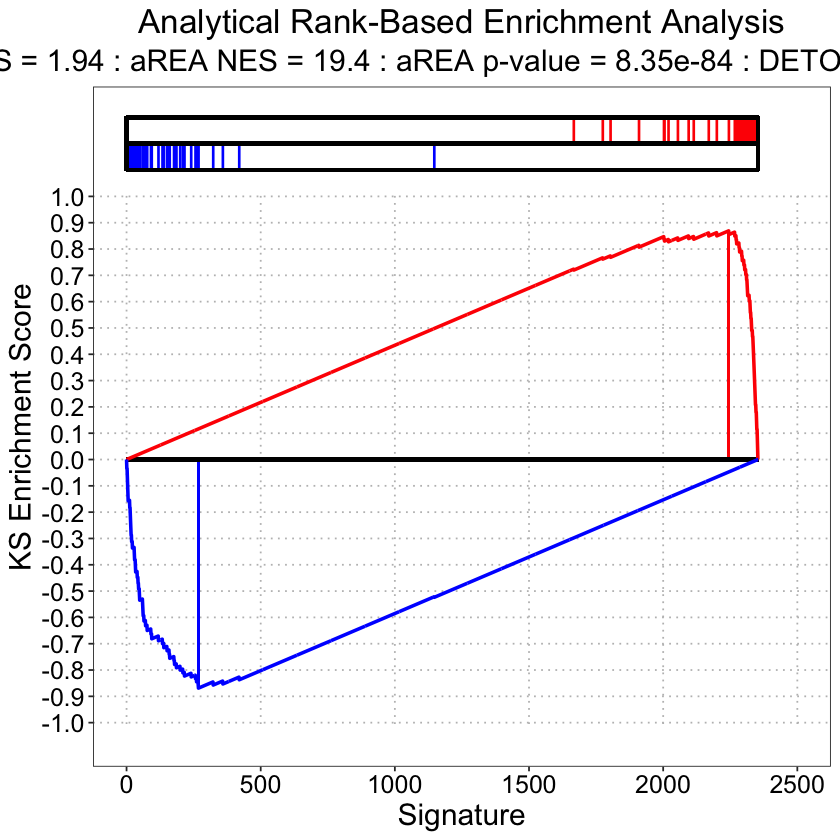

In [8]:
#Using input consensus signature and VUFS matrix (one mutation at a time), generating the aREA plot
current.geneset<-ref.sig
plot.data <- test.vpmat
current.sig<-plot.data[,colnames(plot.data)==colnames(test.vpmat)[1]]
sort.current.sig<-sort(current.sig,decreasing = TRUE)
a.p<-aREA_GSEA_Plot(current.geneset,current.sig,uniform.wts = TRUE,
                      tcm.size,color.positive = "red", color.negative = "blue",
                      main.title = paste0('Analytical Rank-Based Enrichment Analysis'), 
                      y.label = "KS Enrichment Score", x.label = "Signature", 
                      x.step = 500, y.step = 0.1,gsea.score = 1)
#pdf(paste('aREA.pdf', sep=""),width = 15, height = 10, family = "Times", pointsize = 8)
print(a.p)
#dev.off()
  